# ДЗ 1
## Классический МЛ в NLP, вспомнить все!

В этом ДЗ будем работать с датасетом Men_Women_Shoes_Reviews ttps://www.kaggle.com/daishinkan002/men-women-shoes-reviews 
 

### **Задание 1**. 
Предсказать цену по описанию товара (для каждого товара)
### **Задание 2.** 
Предсказать оценку товара пользователем по его отзыву (для каждого отзыва)

## *Что нужно сделать в каждом задании:* 
1) проанализировать данные (все, на что хватит вашей фантазии, хороший анализ включает в себя графики и статистические инструменты анализа, можно приходить с вопросами "какой инструмент поможет мне проверить такую-то гипотезу/хочу посмотреть вот это вот, как это сделать", предварительно не стесняйтесь гуглить) **1 балл**

2) подготовить данные (стемминг, лемматизация, убрать мусор и стоп-слова, нормализовать... все, что покажется вам разумным относительно данных, но вы должны кратко (комментарием к этому блоку кода в тетрадке) объяснить почему вы сделали именно такой препроцессинг. Хороший препроцессинг - разумный, в данном случае чем больше тем не всегда лучше) **1 балла**

3) векторизовать тексты (контекстуальные эммбединги пока что не берем, только BoW и TF-IDF) **0.5 балл**

4) сделать гридсерч по нескольким моделям (у нас 2 задания, классификация и регрессия), подобрать гиперпараметры, выбрать лучшую модель, рассказать, почему, на ваш взгляд,лучший результат показал лучший алгоритм **1 балл**

5) оценить и проанализировать качество лучших решений для каждой задачи (рассказать с чем ваша модель справляется хорошо, а где у нее "слабые места", можно ли как-то улучшить ваши результаты. Хороший анализ сопровождается графиками) **1,5 балла** 

Максимальная сумма баллов при выполнении 5 пунктов в 2 заданиях - 10

В тетрадке с первого занятия много дополнительной информации, которая может вам помочь, но все равно не стесняйтесь приходить с вопросами в чат курса. 

In [327]:
import zipfile
import pandas as pd
import os
import re
from langdetect import detect
import spacy
import matplotlib.pyplot as mpl
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV

In [480]:
path_to_file = r'C:\Users\VADIK\Documents\ВШЭ\final\data\NN-methods-2021-2022\HW_1\archive.zip'
path = r'C:\Users\VADIK\Documents\ВШЭ\final\data\NN-methods-2021-2022\HW_1'
with zipfile.ZipFile(path_to_file, 'r') as zip_ref:
    zip_ref.extractall(path)

In [481]:
path = r'C:\Users\VADIK\Documents\ВШЭ\final\data\NN-methods-2021-2022\HW_1'
data = pd.read_csv(os.path.join(path, 'Shoes_Data.csv'), 
                 sep=',',
                 header=0
                )
data.columns

Index(['title', 'price', 'rating', 'total_reviews', 'product_description',
       'reviews', 'reviews_rating', 'Shoe Type'],
      dtype='object')

Проверим на наличие пустых значений.

In [482]:
assert data[data['title'].isna()].shape[0] == 0
assert data[data['price'].isna()].shape[0] == 0
assert data[data['rating'].isna()].shape[0] == 0
assert data[data['total_reviews'].isna()].shape[0] == 0
assert data[data['product_description'].isna()].shape[0] == 0
assert data[data['reviews'].isna()].shape[0] == 0
assert data[data['reviews_rating'].isna()].shape[0] == 0
assert data[data['Shoe Type'].isna()].shape[0] == 0

Уберем все дубликаты.

In [483]:
data.shape

(1230, 8)

In [484]:
data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)

In [485]:
data.shape

(1015, 8)

# Задание 1

Выбираю все признаки, кроме отзыва и оценки отзыва.

In [486]:
df = data[['title', 'product_description', 'rating', 'total_reviews', 'price', 'Shoe Type']]

Больше дубликатов не появилось.

In [487]:
df.drop_duplicates().shape

(1015, 6)

### Язык

In [488]:
def detect_lang(x):
    try:
        lang = detect(x)
    except Exception as e:
        lang = str(Exception)
    return lang

In [489]:
%%time
df['title_lang'] = df['title'].transform(lambda x: detect_lang(x))

Wall time: 19.7 s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [490]:
%%time
df['description_lang'] = df['product_description'].transform(lambda x: detect_lang(x))

Wall time: 7.86 s


Визуально становится понятно, что все наименования, язык которых не определен как английский, все-таки написаны на нем. Хочется оставить названия, потому что цена может зависеть от бренда.

In [491]:
df[df['title_lang'] != 'en']['title'].unique().tolist()

["Bourge Men's Loire-z126 Running Shoes",
 "T-Rock Men's Sneaker",
 "Sparx Men's Sd0323g Sneakers",
 "Knoos Men's Loafer",
 "road runner Men's Sneaker Shoes",
 'Kraasa Sneakers for Men',
 'FLITE Men Boat Shoes',
 "BATA Men's Wonder Rain Shoe",
 "Paragon Men's Flip-Flops",
 "Aqualite Men's Eal00636g Clog",
 "BATA Men's Swift Loafers",
 "BATA Men's Denim Sneaker",
 "Kraasa Men's Sports Shoe",
 'GoldStar Running Running Shoes for Men (Blue)',
 "AADI Men's Running Shoe",
 "BATA Men's Walking Shoe",
 "Kraasa Men's Running Shoe",
 'Kraasa Tesla-44 Running Shoes for Men',
 "Aqualite Men's Eal00631g Clog",
 'Kraasa Series 07 Sneakers for Men',
 "ASIAN Men's Future-01 Running Shoes",
 "ASIAN Men's Wonder-13 Sports Running Shoes",
 "BATA Men's Skyline Sneaker",
 "Aqualite Men's Eal00636g Sandal",
 "Sparx Men's Sm-402 Sneakers",
 'Centrino Men 7104 Loafers',
 'BATA Men Supermatch Sneakers',
 "Centrino Men's 9920-01 Loafer",
 "Unistar Men's Running Shoes",
 'Robbie jones Men Casual Sneakers Shoes'

Количество описаний не на английском значительно меньше. Посмотрим и на них.

In [492]:
df[df['description_lang'] != 'en'].shape

(33, 8)

In [493]:
pd.options.display.max_colwidth = 10000000
df[df['description_lang'] != 'en'][['product_description']]

,product_description
14,AADI SHOES
203,Lotto carmela sport running shoe for men.
298,Sir Corbett Men's Jogging Sports Shoes
343,Furo R1013 Red running sport shoes for men.
383,Closure : Lace up
405,Red Chief మీ ముందుకు తీసుకువచ్చిన ఈ లెదర్ పురుషుల స్లిప్పర్లలో సౌకర్యవంతంగా ఉండండి. పాడింగ్ యొక్క డబుల్ లేయర్ తో పూర్తి మెత్తటి ఎగువ మరియు ఫుట్-బెడ్ మీ సాధారణ వస్త్రధారణకు ఈ స్లిప్పర్లను అంతిమ ఎంపికగా మార్చడానికి తీవ్రమైన కుషనింగ్ మరియు సౌకర్యాన్ని అందిస్తుంది.______Stay comfortable in these leather men's Slippers brought to you by Red Chief. Fully padded upper and foot-bed with double layer of padding provides extreme cushioning and comfort to make these Slippers the ultimate choice for your casual attire.______Red Chief மூலம் உங்களிடம் கொண்டு வரும் இந்த தோல் ஆண்கள் செருப்புகளில் வசதியாக இருங்கள். பேடிங் இரட்டை அடுக்கு பேடிங் கொண்ட முழுமையாக பேட் செய்யப்பட்ட மேல் மற்றும் கால் படுக்கை இந்த ஸ்லிப்பர்களை உங்கள் கேஷுவல் உடைகளுக்கு இறுதி தேர்வாக மாற்ற உதவுகிறது.______Red Chief-ൽ നിന്നുള്ള ഈ ലെതർ പുരുഷന്മാരുടെ സ്ലിപ്പറുകൾ നിങ്ങൾക്കൊപ്പം സുഖമായിരിക്കൂ. ഇരട്ട പാളികളോടു കൂടിയ പൂർണ്ണമായും പാഡ് ചെയ്ത മുകൾ ഭാഗവും ഫൂട്ട്-ബെഡും ഈ സ്ലിപ്പറുകൾ നിങ്ങളുടെ കാഷ്വൽ വസ്ത്രത്തിനുള്ള ഏറ്റവും മികച്ച ചോയ്സാക്കി മാറ്റുന്നു.______Red Chief द्वारा आपके लिए लाए गए इन लेदर पुरुषों के स्लिपर में आरामदायक रहें. पैडिंग की डबल लेयर के साथ पूरी तरह से पैडेड अपर और फुट-बेड इन स्लिपर को आपके कैज़ुअल पोशाक के लिए सबसे बढ़िया विकल्प बनाने के लिए अत्यधिक कुशनिंग और आराम प्रदान करता है.______Red Chief ಅವರು ನಿಮಗೆ ತಂದಿರುವ ಈ ಚರ್ಮದ ಪುರುಷರ ಚಪ್ಪಲಿಗಳಲ್ಲಿ ಆರಾಮವಾಗಿರಿ. ಪ್ಯಾಡಿಂಗ್ ನ ಎರಡು ಪದರದೊಂದಿಗೆ ಸಂಪೂರ್ಣ ಪ್ಯಾಡೆಡ್ ಮೇಲಿನ ಮತ್ತು ಪಾದದ ಹಾಸಿಗೆ ಈ ಚಪ್ಪಲಿಗಳನ್ನು ನಿಮ್ಮ ಕ್ಯಾಶುಯಲ್ ಉಡುಪಿಗೆ ಅಂತಿಮ ಆಯ್ಕೆಯನ್ನಾಗಿ ಮಾಡಲು ವಿಪರೀತ ಮೆತ್ತನೆಯ ಮತ್ತು ಸೌಕರ್ಯವನ್ನು ಒದಗಿಸುತ್ತದೆ.
417,
470,PUMA Men Flex Generation V1 IDP Sneaker
502,Aaron.
578,సరళమైన మరియు కనిష్ట డిజైన్ సౌకర్యంతో కలపడం మరియు ఫ్యాషన్లో సరికొత్తగా మీ డిమాండ్కు అనుగుణంగా ఉంటుంది మాగ్నెటిక్ ఫ్యాషన్ ప్రతి సందర్భానికి పరిపూర్ణంగా కనిపించాలనుకునే పురుషుల కోసం అద్భుతమైన పాదరక్షలను అందిస్తుంది. ఈ పరిధి సున్నితమైనది నాగరీకమైనది మరియు సౌకర్యవంతమైనది. స్టైలిష్ మరియు క్లాస్సి ఈ సేకరణను సరిగ్గా నిర్వచించే పదాలు. ప్రతి స్టైల్ పాదరక్షల అభిరుచిని మరియు మెటీరియల్ మరియు డిజైన్పై లోతైన అవగాహనను ప్రతిబింబిస్తుంది______Simple and minimal design combining with comfort and falling in line with your demand for the latest in fashion Magnetic Fashion presents an amazing range of footwear for men who want to look perfect for every occasion. This range is suave fashionable and comfortable. Stylish and classy are the words that define this collection perfectly. Each style reflects passion for footwear and deep understanding of materials and design______ലളിതവും കുറഞ്ഞതുമായ രൂപകൽപ്പന സുഖസൗകര്യങ്ങളുമായി സംയോജിപ്പിച്ച് ഏറ്റവും പുതിയ ഫാഷനായുള്ള നിങ്ങളുടെ ആവശ്യത്തിന് അനുസൃതമായി Magnetic Fashion എല്ലാ അവസരങ്ങളിലും മികച്ചതായി കാണാൻ ആഗ്രഹിക്കുന്ന പുരുഷന്മാർക്ക് വേണ്ടിയുള്ള അതിശയകരമായ പാദരക്ഷകളുടെ ശ്രേണി അവതരിപ്പിക്കുന്നു. ഈ ശ്രേണി ഇണക്കമുള്ളതും ഫാഷനബിളും സുഖകരവുമാണ്. ഈ ശേഖരത്തെ തികച്ചും നിർവചിക്കുന്ന പദങ്ങളാണ് സ്റ്റൈലിഷും ക്ലാസിയും. ഓരോ സ്റ്റൈലും പാദരക്ഷകളോടുള്ള അഭിനിവേശത്തെയും മെറ്റീരിയലുകളെയും രൂപകൽപ്പനയെയും കുറിച്ചുള്ള ആഴത്തിലുള്ള ധാരണയെയും പ്രതിഫലിപ്പിക്കുന്നു.______வசதியோடு இணைந்த எளிய மற்றும் குறைந்தபட்ச வடிவமைப்பு சமீபத்திய ஃபேஷனுக்கான உங்கள் கோரிக்கைக்கு ஏற்ப Magnetic Fashion ஒவ்வொரு சந்தர்ப்பத்திற்கும் சரியானதாக இருக்க விரும்பும் ஆண்களுக்கான அற்புதமான பாதணிகளை வழங்குகிறது. இந்த வரம்பு மென்மையானது நாகரீகமானது மற்றும் வசதியானது. ஸ்டைலான மற்றும் கம்பீரமான இந்த தொகுப்பை கச்சிதமாக வரையறுக்கும் சொற்கள். ஒவ்வொரு ஸ்டைலும் காலணிகளுக்கான பேரார்வத்தையும் மெட்டீரியல்கள் மற்றும் டிஸைனின் ஆழமான புரிதலையும் பிரதிபலிக்கிறது______ಆರಾಮದೊಂದಿಗೆ ಸಂಯೋಜಿಸುವ ಸರಳ ಮತ್ತು ಕನಿಷ್ಠ ವಿನ್ಯಾಸ ಮತ್ತು ಫ್ಯಾಷನ್ನಲ್ಲಿನ ನಿಮ್ಮ ಬೇಡಿಕೆಗೆ ಅನುಗುಣವಾಗಿ ಬೀಳುತ್ತದೆ Magnetic Fashion ಪ್ರತಿ ಸಂದರ್ಭಕ್ಕೂ ಪರಿಪೂರ್ಣವಾಗಿ ಕಾಣಲು ಬಯಸುವ ಪುರುಷರಿಗೆ ಅದ್ಭುತ ಶ್ರೇಣಿಯ ಪಾದರಕ್ಷೆಗಳನ್ನು ಒದಗಿಸುತ್ತದೆ. ಈ ಶ್ರೇಣಿಯು ನಯ ಫ್ಯಾಶನ್ ಮತ್ತು ಆರಾಮದಾಯಕವಾಗಿದೆ. ಶೈಲಿಯ ಮತ್ತು ಕ್ಲಾಸಿ ಈ ಸಂಗ್ರಹವನ್ನು ಸಂಪೂರ್ಣವಾಗಿ ವ್ಯಾಖ್ಯಾನಿಸುವ ಪದಗಳಾಗಿವೆ. ಪ್ರತಿಯೊಂದು ಶೈಲಿಯು ಪಾದರಕ್ಷೆಗಳ ಬಗೆಗಿನ ಉತ್ಸಾಹವನ್

Оказывается, что некоторые из них просто слишком короткие, другие — представлены на разных языках. Так как количество описаний небольшое, их можно просмотреть и поправить вручную.

In [494]:
df.loc[405, 'product_description'] = """Stay comfortable in these leather men's Slippers brought to you by Red Chief. Fully padded upper and foot-bed with double layer of padding provides extreme cushioning and comfort to make these Slippers the ultimate choice for your casual attire."""
df.loc[578, 'product_description'] = """Simple and minimal design combining with comfort and falling in line with your demand for the latest in fashion Magnetic Fashion presents an amazing range of footwear for men who want to look perfect for every occasion. This range is suave fashionable and comfortable. Stylish and classy are the words that define this collection perfectly. Each style reflects passion for footwear and deep understanding of materials and design"""
df.loc[732, 'product_description'] = """Keep your options super flexible and comfortable with suave style in the SKECHERS Moreway - Chapson shoe. Soft woven mesh fabric and smooth synthetic upper in a slip on casual comfort loafer styled boat shoe with stitching and overlay accents. Air Cooled Memory Foam insole. Construction Soft smooth woven mesh fabric upper Smooth synthetic overlays at collar and heel Slip on casual comfort loafer moc boat shoe design Stitching accents Stitched raised seam accented moc toe front Breathable mesh fabric with smooth solid look Tone-on-tone synthetic overlays at collar and heel panel Smooth refined loafer design with plain Venetian front and rolled stitch detailing at sides Heel panel overlay with stitched edging Slip on design with flexible comfort instep panel Padded collar Soft fabric shoe lining Air Cooled Memory Foam cushioned comfort insole Goga Mat Arch cushion for added support Very lightweight shock absorbing midsole with articulated design Flexible siped traction outsole 1 inch heel Keep your options super flexible and comfortable with suave style in the SKECHERS Moreway - Chapson shoe. Soft woven mesh fabric and smooth synthetic upper in a slip on casual comfort loafer styled boat shoe with stitching and overlay accents. Air Cooled Memory Foam insole. Construction Soft smooth woven mesh fabric upper Smooth synthetic overlays at collar and heel Slip on casual comfort loafer moc boat shoe design Stitching accents Stitched raised seam accented moc toe front Breathable mesh fabric with smooth solid look Tone-on-tone synthetic overlays at collar and heel panel Smooth refined loafer design with plain Venetian front and rolled stitch detailing at sides Heel panel overlay with stitched edging Slip on design with flexible comfort instep panel Padded collar Soft fabric shoe lining Air Cooled Memory Foam cushioned comfort insole Goga Mat Arch cushion for added support Very lightweight shock absorbing midsole with articulated design Flexible siped traction outsole 1 inch heel"""
df.loc[765, 'product_description'] = """Team up with the ultimate in stretch flexible comfort and sleek style in the SKECHERS Ultra Flex 2.0 - Mirkon shoe. Skech Knit Mesh soft woven nearly one piece fabric upper in a slip on sporty comfort walking and training sneaker. Air Cooled Memory Foam insole highly flexible comfort midsole. Construction Skech Knit Mesh soft woven nearly one piece fabric upper Slip on sporty walking and training sneaker design Woven-in contrast knit detail on instep and heel panel Stretch Fit design with woven texture knit detail Solid or lightly heathered finish knit for sporty look Contrast knit diagonal instep panel with texture finish Side S logo Stretch fit design front and instep for soft snug fit High apex front and heel for added comfort Heel and instep fabric overlays with pull on top tabs Padded collar and tongue Soft fabric shoe lining Air Cooled Memory Foam cushioned comfort insole Ultra Flex 2.0 midsole with superior impact cushioning protection and remarkable energy return Highly flexible articulated midsole and outsole design for freedom of movement Textured channel design midsole finish Flexible outsole with flexible articulated traction design 1 1/4 inch heel Machine Washable design - Gentle Cycle cold hang up to air dry"""
df.loc[767, 'product_description'] = """Description Advanced technology takes on the great outdoors with the Skechers Bionic Trail™. This all terrain hiking and trail running shoe is designed with a lightweight water repellent upper cushioned midsole and a durable Goodyear® rubber traction outsole. Features Lightweight breathable mesh fabric upper with synthetic overlays Water repellent upper design Soft stretch collar for easy slip on fit High apex design with lace up front for secure fit Skeletal side TPU panels for added stability and lace-through comfort Hot melt synthetic toe and heel overlays for added durability Air-Cooled Memory Foam cushioned comfort insole Lightweight shock absorbing midsole with stabilzed midfoot Midsole with speckle design finish Goodyear® rubber outsole provides durability and traction Durable tread outsole provides ample multi-surface traction Weight: 9 oz. in a men's size 9 Padded collar and heel panel for sure fit Goodyear® (and the winged foot design) and Blimp are trademarks of The Goodyear Tire & Rubber Company used under license by Skechers USA Inc. Manhattan Beach CA. Copyright 2019 The Goodyear Tire & Rubber Company. This or any footwear cannot completely eliminate the risk of slipping"""
df.loc[774, 'product_description'] = """Super Critical Foam™ Built for the long run the lightweight Skechers GO RUN Maxroad 4 Hyper™ is an ultra cushioned neutral road running shoe. Designed with highly-resilient HYPER BURST® cushioning a durable rubber outsole and forefoot flex grooves for a smooth transition. The Skechers GO RUN Maxroad 4 Hyper™ provides cushioning for the miles ahead. Features Breathable compression knit fabric upper provides a snug and sock-like fit Upper material provides a multi-zone stretch Material designed to stretch in areas while providing structure and durability where needed Highly responsive ultra-lightweight long-lasting HYPER BURST™ cushioning midsole HYPER BURST™ is a new midsole foam created using a 'Super Critical™' process The process creates an extremely lightweight and resilient material for long wearing durability and responsiveness Rubber outsole promotes durabilty for smooth surface running Strategically-placed rubber pillars provide cushioning Knit collar provides a more comfortable and supportive fit Forefoot flex grooves aid in flexibility and promote a smooth transition Removable insole for a custom fit Offset: 6mm Weight: 8.4 oz. per shoe in a men's size 9 Compression knit mesh fabric upper provides a sock-like fit Woven-in sporty two color design Side S logo Lace up design with soft knit collar for comfortable feel Tongue free design for smooth comfortable fit"""
df.loc[800, 'product_description'] = """Nike Footwear are made with premium quality material and gives ultimate comfort"""
df.loc[878, 'product_description'] = """This Aqualite Shoes will be a great choice for you if you are a comfort freak. We are the best quality providers with the best comfort for the Shoess comes in this range. So Hurry up and join our league of Comfort Dikhta Hai."""
df.loc[924, 'product_description'] = """The peach shoes Mode by Red Tape are Hergestellt in a slip-on design with breathable textile upper and EVA sole for added flexibility and impact resistance. The ultra-modern pair features a white sole for extra edge of visual appeal. Team them with soft colored outfits to exude sophistication."""
df.loc[937, 'product_description'] = """Shine like the bright summer sun in easy-wearing comfort with the SKECHERS Relaxed Fit: Granola - Bloom Farm sandal. Smooth metallic-finish synthetic upper in a casual comfort two strap slide sandal with classic look adjustable buckles and Luxe Foam footbed. Construction Smooth synthetic 'duraleather' upper with metallic finish Classic comfort two strap slide sandal design Stitching accents Straps features adjustable metal buckles with SKECHERS logo accents Hidden elastic panel under buckles for added comfort Solid side wrap panels for added comfort Soft fabric strap lining Relaxed Fit design for roomy comfortable fit Luxe Foam full length cushioned comfort insole Contoured footbed design for added support and comfort Shock absorbing supportive lightweight midsole Natural cork veneer midsole trim Flexible rubber high traction outsole 1 inch heel height."""
df.loc[956, 'product_description'] = """Fun sculpted style meets advanced walking comfort in the Cali Gear: Skechers GOwalk 5™ - Astonished. Features lightweight responsive ULTRA GO™ cushioning and high-rebound COMFORT PILLAR TECHNOLOGY™ for the ultimate in walking comfort. Sculpted nearly one piece Cali Gear® slip on clog design. Details Lightweight responsive ULTRA GO™ cushioning High-rebound COMFORT PILLAR TECHNOLOGY™ underfoot react to your every step for the ultimate comfort Dual density outsole for added stability and support Sculpted Cali Gear® EVA lightweight flexible upper Weight: 4.55 oz. per shoe in a women's size 7 1 1/2 inch heel Construction Cali Gear® design sculpted nearly one piece upper Solid color EVA in a backless slip on sport clog with convertible strap Closed toe design with all over sculpted perforation detail Convertible heel sling strap with side pivot points Sculpted logo detail Smooth soft interior and contoured comfort footbed Draining design on footbed and midsole Water friendly design Easy to clean - hand wash dry in shade"""
df.loc[969, 'product_description'] = """NIKE City Trainer 3 training shoes are designed for both gym and outdoor exercise. Features breathable and durable mesh upper comes with soft phylon foam for supportive to keep your foot comfortable and contained"""
df.loc[978, 'product_description'] = """Reebok Women's LITE 2.0 BLACK/TRGRY1/HORBLU Running Shoe (FU8545)"""
df.loc[989, 'product_description'] = """The Nike quest 2 combines a technical look with an ultra-breathable upper of open-hole Mesh. The 2-tone laces weave in and out of flywire cables for stylish support."""
df.loc[991, 'product_description'] = """Find the ultimate in flexible comfort and sleek sporty style with the SKECHERS Ultra Flex 2.0 - Lite-Groove shoe. Soft engineered mesh fabric upper in a slip on bungee laced sporty comfort walking and training sneaker with woven-in textured designs. Air Cooled Memory Foam insole highly flexible comfort midsole. Construction Engineered Mesh soft nearly one piece fabric upper Slip on bungee laced sporty walking sneaker design Stitching accents Contrast colored synthetic trim at heel and tongue Woven-in mesh texture design with sporty pattern detail Interwoven ventilating panels Side S logo Bungee stretch laced front panel for slip on ease High apex front and heel for added comfort Heel and instep fabric overlays with pull on instep tabs Subtle glitter pattern accents at heel and tongue overlays Padded collar and tongue Soft fabric shoe lining Air Cooled Memory Foam cushioned comfort insole Ultra Flex 2.0 midsole with superior impact cushioning protection and remarkable energy return Highly flexible articulated midsole and outsole design for freedom of movement Textured channel design midsole finish Flexible outsole with flexible articulated traction design 1 1/4 inch heel"""
df.loc[999, 'product_description'] = """Nike shoes are lightweight and durable – Despite provides exceptional comfort flexibility of Nike shoes are very light. If you buy a pair of Nike shoes for specific sports you will definitely reap the benefits for a long time."""
df.loc[1013, 'product_description'] = """The Nike women's running shoe feels and even looks soft and plush. Yet it provides incredible support to help you run your best from your first 5K to your latest marathon and delivers an ultra-responsive feel with each stride."""

In [495]:
%%time
df['description_lang'] = df['product_description'].transform(lambda x: detect_lang(x))

Wall time: 7.35 s


В конечном итоге как тексты на английском не определяются только короткие или отсутствующие описания.

In [496]:
pd.options.display.max_colwidth = 100
print(df[df['description_lang'] != 'en'].shape)
df[df['description_lang'] != 'en'][['product_description']]

(16, 8)


,product_description
14,AADI SHOES
203,Lotto carmela sport running shoe for men.
298,Sir Corbett Men's Jogging Sports Shoes
343,Furo R1013 Red running sport shoes for men.
383,Closure : Lace up
417,
470,PUMA Men Flex Generation V1 IDP Sneaker
502,Aaron.
602,BAMPTON UP MAHOGANY LEATHER
677,Ernest Limit Black Leather.


In [497]:
df.drop(['title_lang', 'description_lang'], axis=1, inplace=True)

### Валюта

Проверим, что все цены указаны в одной валюте.

In [498]:
df['currency'] = df['price'].transform(lambda x:x[0])
df[df['currency'] != '₹']

,title,product_description,rating,total_reviews,price,Shoe Type,currency


### Лемматизация и длина описаний

In [499]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [500]:
def lemmatization(sentence, nlp):
    doc = nlp(sentence)
    return [token.lemma_.lower() for token in doc if re.sub('[^a-z]', '', token.lemma_.lower()).isalpha()]

In [501]:
%%time
df['lem_title'] = df['title'].transform(lambda x: lemmatization(x, nlp))

Wall time: 2.47 s


In [502]:
%%time
df['lem_product_description'] = df['product_description'].transform(lambda x: lemmatization(x, nlp))

Wall time: 5.94 s


In [503]:
df['description_length'] = df['lem_product_description'].transform(lambda x: len(x))

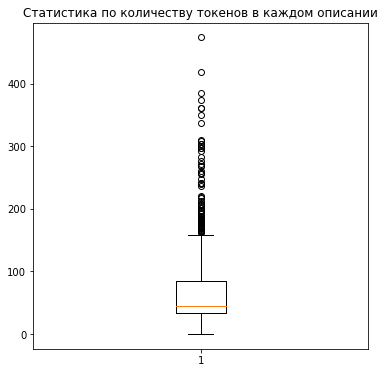

In [504]:
mpl.figure(figsize=[6, 6])
mpl.boxplot(df['description_length'])
mpl.title('Статистика по количеству токенов в каждом описании')
mpl.show()

Из графика видно, что половина описаний содержит примерно от пятидесяти и меньше токенов. Попробуем также убрать стоп-слова.

### Стопслова
Сначала почистим стоп-слова из nltk.

In [505]:
def remove_stopwords(x, words):
    for i, el in enumerate(x):
        if el in words:
            x.pop(i)
    return x

In [506]:
%%time
en_stopwords = stopwords.words('english')
df['no_stopwords_title'] = df['lem_title'].transform(lambda x: remove_stopwords(x, en_stopwords))
df['no_stopwords_description'] = df['lem_product_description'].transform(lambda x: remove_stopwords(x, en_stopwords))
df['no_stopwords_description_length'] = df['no_stopwords_description'].transform(lambda x: len(x))

Wall time: 146 ms


Посмотрим, сколько лемм осталось на данном этапе.

In [508]:
lemmas = pd.DataFrame(df['no_stopwords_description'].sum())
lemmas['count'] = 1
lemmas = lemmas.groupby(0).count().sort_values('count', ascending=False)
lemmas.shape[0]

3523

Посмотрим на распределение частот этих лемм.

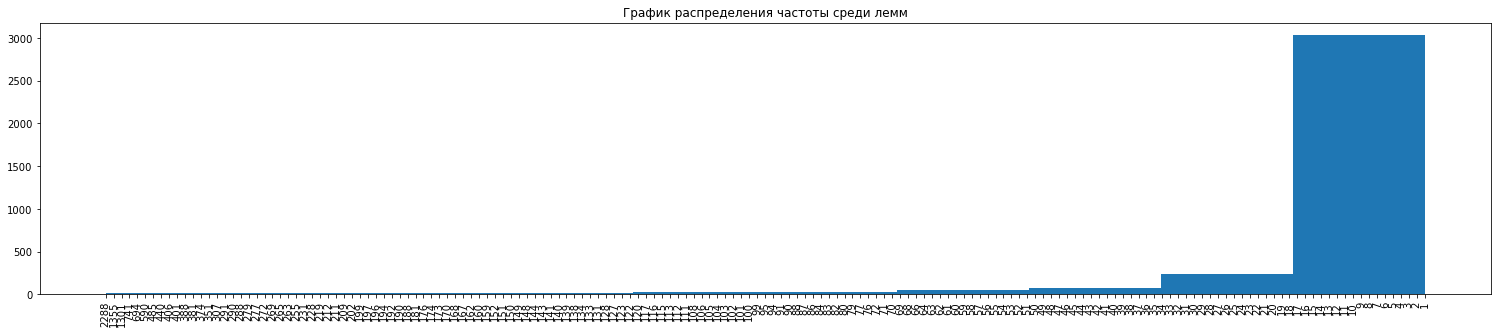

In [509]:
mpl.figure(figsize=[26, 5])
mpl.hist(x=lemmas['count'].transform(lambda x: str(x)))
mpl.xticks(rotation=90)
mpl.title('График распределения частоты среди лемм')
mpl.show()

Посмотрим на верхние значения с частотой больше или равно 200.

In [510]:
lemmas[lemmas['count'] >= 200]

,count
0,
-pron-,2288
the,1355
shoe,1301
comfort,741
design,694
a,590
pair,485
style,440
footwear,406


Уберем некоторые значения.

In [511]:
en_stopwords_additional = [
    '-pron-',
    'the',
    'a',
    'be',
    "'s"
]

Помимо этого, не хочется учитывать слова с корпусной частотой 1, 2.

In [512]:
en_stopwords_additional += lemmas[lemmas['count'] < 3].index.tolist()

In [513]:
%%time
df['no_stopwords_title'] = df['lem_title'].transform(lambda x: remove_stopwords(x, en_stopwords_additional))
df['no_stopwords_description'] = df['lem_product_description'].transform(lambda x: remove_stopwords(x, en_stopwords_additional))
df['no_stopwords_description_length'] = df['no_stopwords_description'].transform(lambda x: len(x))

Wall time: 1.55 s


Сколько лемм осталось:

In [514]:
lemmas.shape[0] - len(en_stopwords_additional)

1672

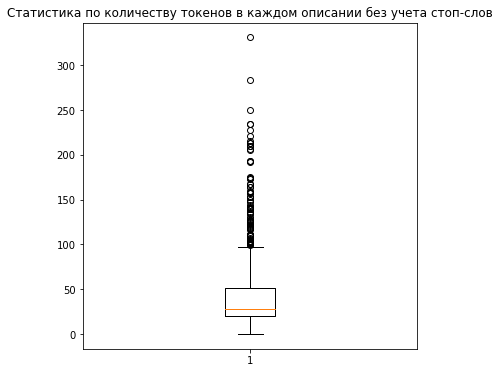

In [515]:
mpl.figure(figsize=[6, 6])
mpl.boxplot(df['no_stopwords_description_length'])
mpl.title('Статистика по количеству токенов в каждом описании без учета стоп-слов')
mpl.show()

Медиана снизилась примерно до 25. Посмотрим долю объектов, в которых длина описания составляет меньше десяти слов без учета стоп-слов.

In [516]:
df[df['no_stopwords_description_length'] < 10].shape[0] / df.shape[0]

0.12019704433497537

12% от выборки — достаточно много. Попробуем другие пороги.

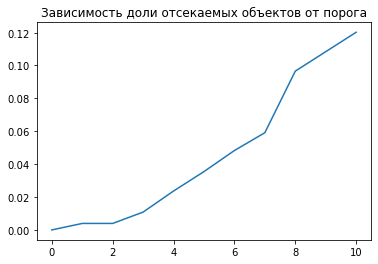

In [517]:
x = []
for i in range(0, 11):
    x.append(df[df['no_stopwords_description_length'] < i].shape[0] / df.shape[0])
mpl.plot(x)
mpl.title('Зависимость доли отсекаемых объектов от порога')
mpl.show()

Кажется, что правильнее будет взять порог 7.

In [518]:
df[df['no_stopwords_description_length'] < 7].shape[0] / df.shape[0]

0.059113300492610835

In [519]:
df[df['no_stopwords_description_length'] < 7].shape[0]

60

In [520]:
df[df['no_stopwords_description_length'] >= 7].shape[0]

955

In [521]:
df = df[df['no_stopwords_description_length'] >= 7].reset_index(drop=True)

In [522]:
df.drop(['title', 'product_description', 'lem_title', 'lem_product_description', 
         'currency', 'description_length', 'no_stopwords_description_length'],
       axis=1, inplace=True)

### Обработка значений

In [523]:
df['rating'] = df['rating'].transform(lambda x: float(x.split(' ')[0]) / 5.0)
df['total_reviews'] = df['total_reviews'].transform(lambda x: int(x.split(' ')[0]))
df['price'] = df['price'].transform(lambda x: float(re.sub('[^\\.\d]', '', x)))

### Рейтинг товара
Слабая связь есть, поэтому попробуем оставить этот признак.

In [524]:
df['rating'].corr(df['price'])

0.27823160412924364

In [525]:
df['rating'].corr(df['price'], method='spearman')

0.37811021502012504

### Количество отзывов
Связи почти нет, этот признак рассматриваться не будет.

In [526]:
df['total_reviews'].corr(df['price'])

-0.09818976131439577

In [527]:
df.drop(['total_reviews'], axis=1, inplace=True)

### Пол

Посмотрим, как распределяется цена в зависимости от пола и долю женских и мужских моделей.

In [528]:
df[df['Shoe Type'] == 'Men'].shape[0] / df.shape[0]

0.7916230366492146

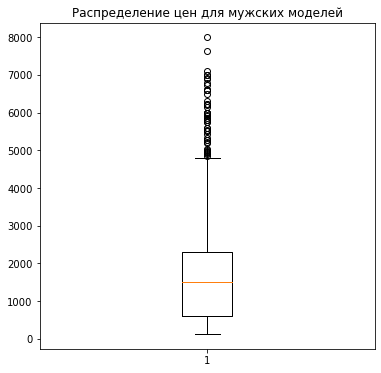

In [529]:
mpl.figure(figsize=[6, 6])
mpl.boxplot(df[df['Shoe Type'] == 'Men']['price'])
mpl.title('Распределение цен для мужских моделей')
mpl.show()

In [530]:
df[df['Shoe Type'] == 'Women'].shape[0] / df.shape[0]

0.20837696335078534

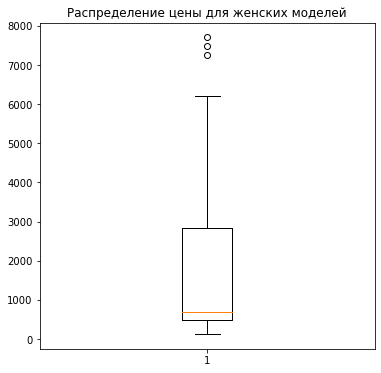

In [531]:
mpl.figure(figsize=[6, 6])
mpl.boxplot(df[df['Shoe Type'] == 'Women']['price'])
mpl.title('Распределение цены для женских моделей')
mpl.show()

Очень неуравновешанная выборка и разница в медицанах всего около 1000 руб. Этот признак рассматриваться не будет.

In [532]:
df.drop(['Shoe Type'], axis=1, inplace=True)

### Векторизация

В качестве метода векторизации попробуем BoW и TF-IDF.

Готовим корпус.

In [533]:
y = np.array([df['price']]).T

In [534]:
df['text'] = (df['no_stopwords_title'] + df['no_stopwords_description']).transform(lambda x: ' '.join(x))

In [535]:
bow_vectorizer = CountVectorizer()
bow_X = bow_vectorizer.fit_transform(df['text'])
bow_X = np.concatenate((bow_X.toarray(), np.array([df['rating']]).T), axis=1)

In [536]:
X_train_bow, X_test_bow, y_train, y_test = train_test_split(bow_X, y, test_size=0.2, random_state=0)

In [537]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_X = tfidf_vectorizer.fit_transform(df['text'])
tfidf_X = np.concatenate((tfidf_X.toarray(), np.array([df['rating']]).T), axis=1)

In [538]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(tfidf_X, y, test_size=0.2, random_state=0)

### Обучение

In [430]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

### Ridge

In [473]:
%%time
lr = Ridge()
parameter_grid = {
    'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'fit_intercept' : [True, False],
    'normalize' : [True, False]
                 }
grid_search = GridSearchCV(lr, param_grid=parameter_grid, scoring='neg_mean_absolute_error')
grid_search.fit(X_train_bow, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: -708.8520108175927
Best parameters: {'alpha': 0.4, 'fit_intercept': True, 'normalize': True}
Wall time: 6.19 s


In [462]:
lr_bow = Ridge(alpha=0.4, fit_intercept=True, normalize=True)
lr_bow.fit(X_train_bow, y_train)
y_pred = lr_bow.predict(X_test_bow)
print('Score: {}'.format(mean_absolute_error(y_test, y_pred)))

Score: 722.5811496334155


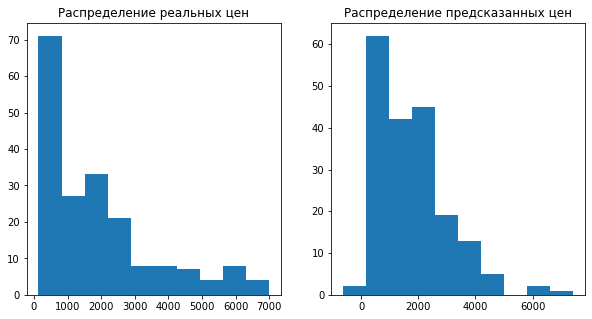

In [463]:
f, (ax1, ax2) = mpl.subplots(1, 2, figsize=[10, 5])
ax1.hist(y_test)
ax1.set_title('Распределение реальных цен')
ax2.hist(y_pred)
ax2.set_title('Распределение предсказанных цен')
mpl.show()

In [393]:
%%time
lr = Ridge()
parameter_grid = {
    'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'fit_intercept' : [True, False],
    'normalize' : [True, False]
                 }
grid_search = GridSearchCV(lr, param_grid=parameter_grid, scoring='neg_mean_absolute_error')
grid_search.fit(X_train_tfidf, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: -684.8187770138364
Best parameters: {'alpha': 0.3, 'fit_intercept': True, 'normalize': False}
Wall time: 5.83 s


In [460]:
lr_tfidf = Ridge(alpha=0.3, fit_intercept=True, normalize=False)
lr_tfidf.fit(X_train_tfidf, y_train)
y_pred = lr_tfidf.predict(X_test_tfidf)
print('Score: {}'.format(mean_absolute_error(y_test, y_pred)))

Score: 686.9142502386867


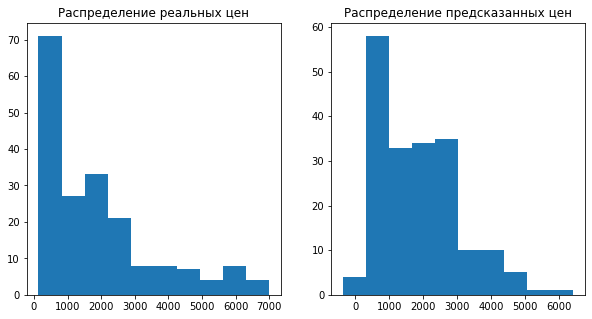

In [461]:
f, (ax1, ax2) = mpl.subplots(1, 2, figsize=[10, 5])
ax1.hist(y_test)
ax1.set_title('Распределение реальных цен')
ax2.hist(y_pred)
ax2.set_title('Распределение предсказанных цен')
mpl.show()

### Decision Tree Regressor

In [541]:
%%time
tree = DecisionTreeRegressor()
parameter_grid = {
    'criterion': ['mae'], # в обновленной версии absolute_error
    'max_depth': [2, 3, 4, 5, 10, 20, 30]
                 }
grid_search = GridSearchCV(tree, param_grid=parameter_grid, scoring='neg_mean_absolute_error')
grid_search.fit(X_train_bow, np.ravel(y_train))
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: -794.0172732198141
Best parameters: {'criterion': 'mae', 'max_depth': 30}
Wall time: 48.1 s


In [542]:
tree_bow = RandomForestRegressor(criterion='mae', max_depth=30)
tree_bow.fit(X_train_bow, np.ravel(y_train))
y_pred = tree_bow.predict(X_test_bow)
print('Score: {}'.format(mean_absolute_error(y_test, y_pred)))

Score: 666.5840227748691


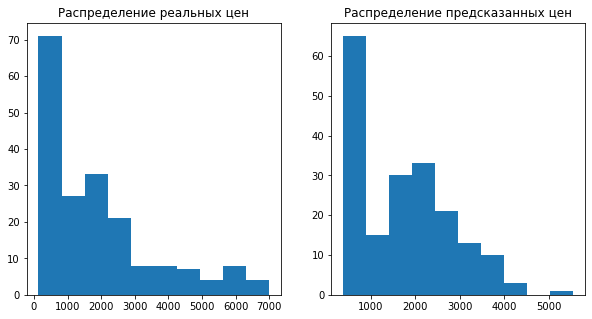

In [543]:
f, (ax1, ax2) = mpl.subplots(1, 2, figsize=[10, 5])
ax1.hist(y_test)
ax1.set_title('Распределение реальных цен')
ax2.hist(y_pred)
ax2.set_title('Распределение предсказанных цен')
mpl.show()

In [544]:
tree_bow = RandomForestRegressor(criterion='mae', max_depth=None)
tree_bow.fit(X_train_bow, np.ravel(y_train))
y_pred = tree_bow.predict(X_test_bow)
print('Score: {}'.format(mean_absolute_error(y_test, y_pred)))

Score: 648.1069471204188


In [545]:
%%time
tree = DecisionTreeRegressor()
parameter_grid = {
    'criterion': ['mae'], # в обновленной версии absolute_error
    'max_depth': [2, 3, 4, 5, 10, 20, 30]
                 }
grid_search = GridSearchCV(tree, param_grid=parameter_grid, scoring='neg_mean_absolute_error')
grid_search.fit(X_train_tfidf, np.ravel(y_train))
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: -821.0508490712075
Best parameters: {'criterion': 'mae', 'max_depth': 30}
Wall time: 1min 1s


In [546]:
tree_tfidf= RandomForestRegressor(criterion='mae', max_depth=30)
tree_tfidf.fit(X_train_tfidf, np.ravel(y_train))
y_pred = tree_tfidf.predict(X_test_tfidf)
print('Score: {}'.format(mean_absolute_error(y_test, y_pred)))

Score: 687.9284968586387


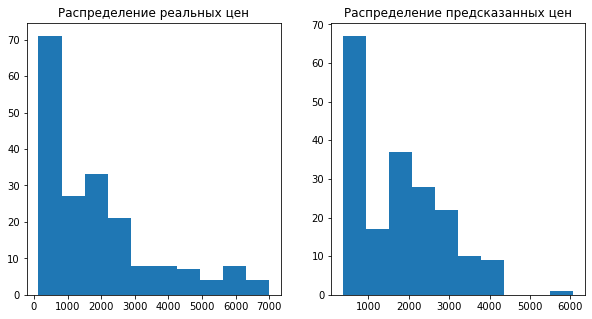

In [547]:
f, (ax1, ax2) = mpl.subplots(1, 2, figsize=[10, 5])
ax1.hist(y_test)
ax1.set_title('Распределение реальных цен')
ax2.hist(y_pred)
ax2.set_title('Распределение предсказанных цен')
mpl.show()

In [548]:
tree_tfidf= RandomForestRegressor(criterion='mae', max_depth=None)
tree_tfidf.fit(X_train_tfidf, np.ravel(y_train))
y_pred = tree_tfidf.predict(X_test_tfidf)
print('Score: {}'.format(mean_absolute_error(y_test, y_pred)))

Score: 685.1377036649216


### Комментарий

Видно, что предсказания "проседают" в первую очередь на выбросах. Помимо этого, можно заметить отличие линейной регрессии от дерева решений: дерево решений в силу того, что считает среднее в листах, никогда не предсказывает нулевое или отрицательное значение. В целом этого можно избежать и в линейной регрессии: в документации sklearn есть параметр posititve, однако на данный момент я его не могу использовать, даже обновив пакет sklearn. 

In [474]:
lr.get_params().keys()

dict_keys(['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'normalize', 'random_state', 'solver', 'tol'])

В случае регрессии лучше сработала BoW векторизация, у дерева — наоборот. Я думаю, что так получилось вследствие того, что дерево выбирает самые важные признаки в каждом узле, а не пытается их взвесить.

В целом, учитывая общее распределение цен, результаты получились средние.